# **Ким Кирилл ИМБО-02-22 Вариант 69**
# КР 2 ММПА

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.signal import argrelextrema

In [258]:
data = np.load('69.npy')
y = pd.Series(data)
y.head()

,0
0,6481.570432
1,6461.431556
2,6493.438003
3,6475.190031
4,6495.221447


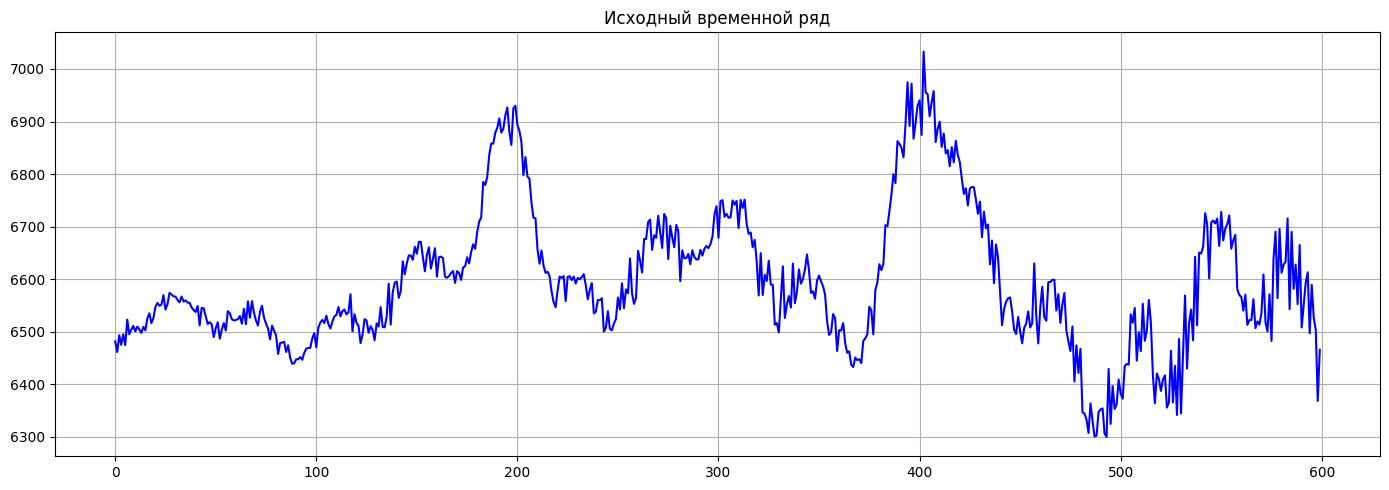

In [259]:
plt.figure(figsize=(14, 5))
plt.plot(y.index, y.values, 'b-')
plt.title("Исходный временной ряд")
plt.grid(True)
plt.tight_layout()
plt.show()

In [260]:
slow = pd.Series(y).rolling(window=30).mean()

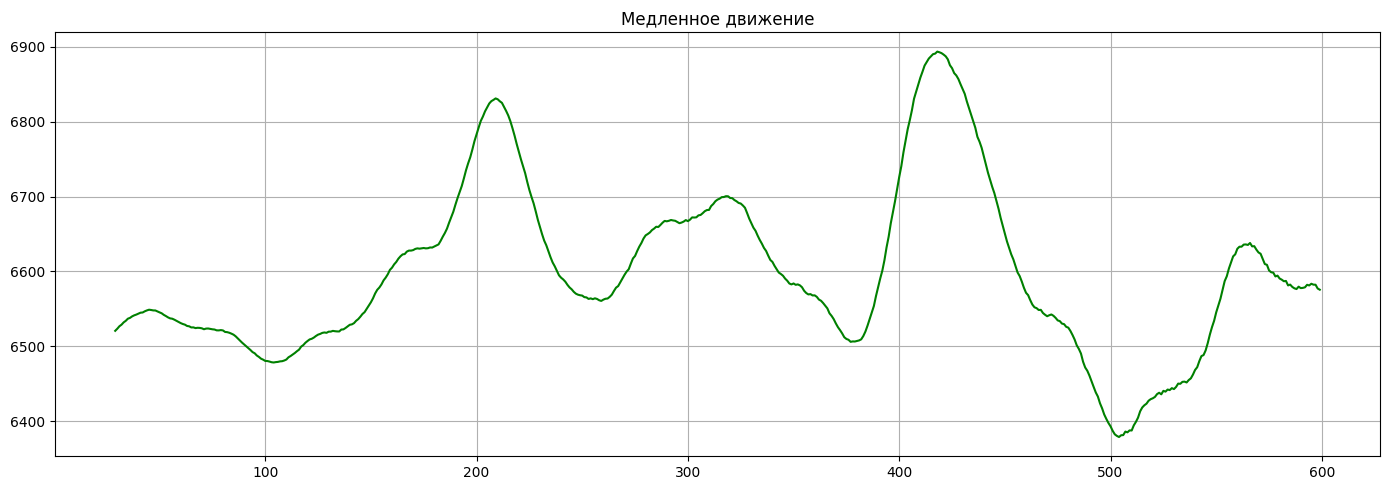

In [261]:
plt.figure(figsize=(14, 5))
plt.plot(slow.index, slow.values, 'g-')
plt.title("Медленное движение")
plt.grid(True)
plt.tight_layout()
plt.show()

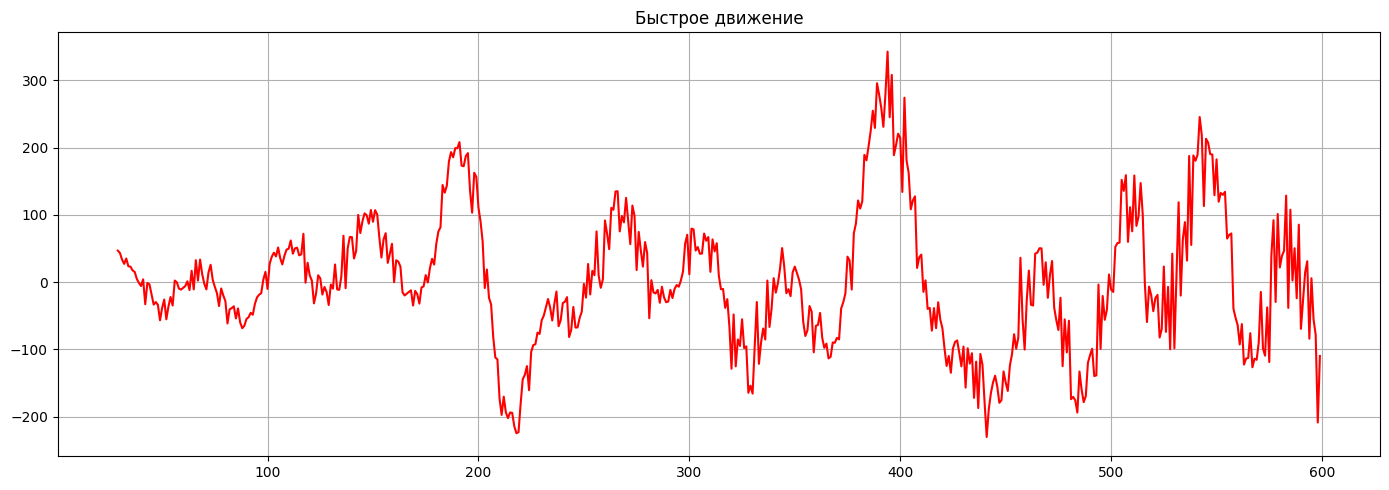

In [262]:
fast = y - slow

plt.figure(figsize=(14, 5))
plt.plot(fast.index, fast.values, 'r-')
plt.title("Быстрое движение")
plt.grid(True)
plt.tight_layout()
plt.show()

In [263]:
best_metric = 100
best_y = None
best_delta = 0
for delta_t in range(len(y) // 2, 1, -1):
    y_left = y.shift(-delta_t)
    y_right = y.shift(delta_t)

    y_shift = np.log((y_left * y_right) / (y**2))
    metric = abs(y_shift.mean() / (y_shift.max() - y_shift.min()))
    if metric < best_metric:
        best_metric = metric
        best_y = y_shift
        best_delta = delta_t
print(f'Лучшая метрика {best_metric} при delta_t {best_delta}')

Лучшая метрика 3.355516266421293e-05 при delta_t 89


In [264]:
n = len(y)
tau_max = 300
tau_values = np.arange(1, tau_max + 1)
a_values = np.zeros(tau_max)

y_left = y.shift(-best_delta)
y_right = y.shift(best_delta)
Z = np.log((y_left * y_right) / (y**2 + 1e-10))

for i, tau in enumerate(tau_values):
    if n - tau - best_delta > 0:
        diff = np.abs(Z.shift(-tau) - Z)
        a_values[i] = diff.iloc[best_delta:n-tau-best_delta].mean()

In [265]:
min_idx = argrelextrema(a_values, np.less)[0]

threshold = np.percentile(a_values, 25)
significant_min_idx = [idx for idx in min_idx if a_values[idx] < threshold]

almost_periods = tau_values[significant_min_idx]

print(f"Значения почти-периодов: {almost_periods}")

Значения почти-периодов: [121 125 208 210 213 216 220 224 226 229 232]


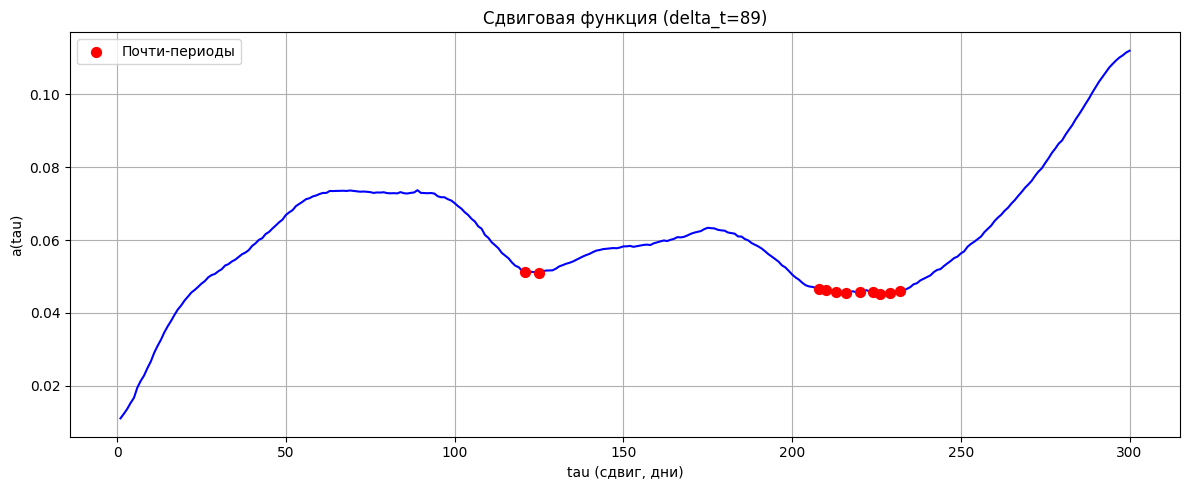

In [266]:
plt.figure(figsize=(12, 5))
plt.plot(tau_values, a_values, 'b-')

plt.scatter(tau_values[significant_min_idx], a_values[significant_min_idx],
            color='red', s=50, zorder=5, label='Почти-периоды')

plt.title(f'Сдвиговая функция (delta_t={best_delta})')
plt.xlabel('tau (сдвиг, дни)')
plt.ylabel('a(tau)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

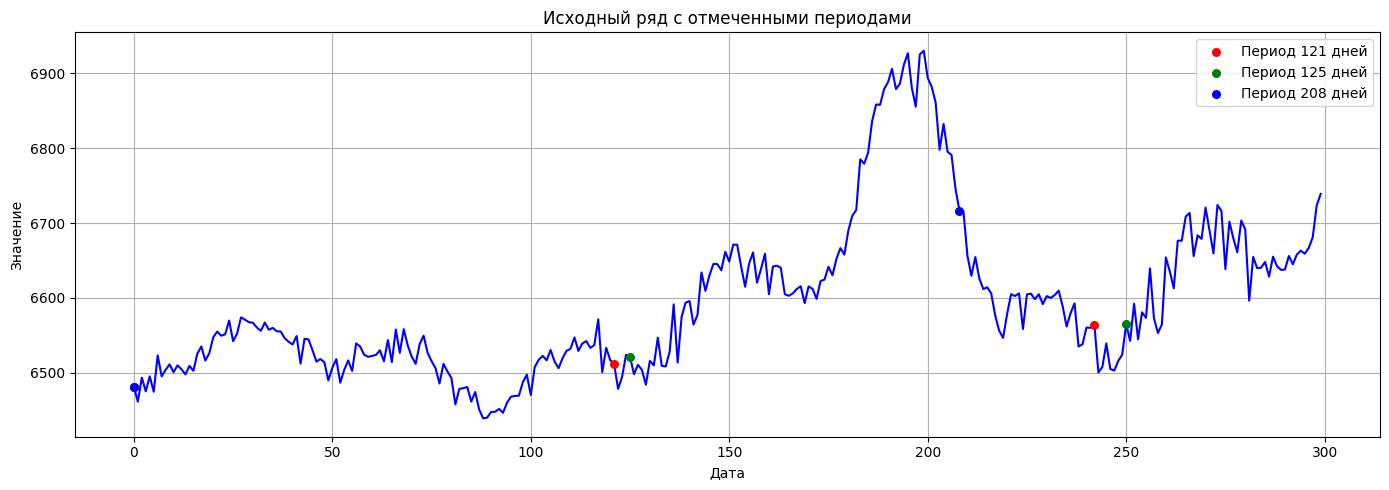

In [267]:
y_sample = y.iloc[:300]

plt.figure(figsize=(14, 5))
plt.plot(y_sample.index, y_sample.values, 'b-')

colors = ['red', 'green', 'blue']
for i, period in enumerate(almost_periods[:3]):
    if period < len(y_sample):
        indices = np.arange(0, len(y_sample), int(period))
        plt.scatter(y_sample.index[indices], y_sample.values[indices],
                    color=colors[i % 3], s=30, zorder=5,
                    label=f'Период {period} дней')

plt.title('Исходный ряд с отмеченными периодами')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [268]:
# Интенсивный рост: 1/y ~ t
y_inv = 1 / (y.values + 1e-10)
t = np.arange(len(y)).reshape(-1, 1)

intense_segments = []
min_len = 30

for start in range(0, len(y) - min_len, 5):
    for end in range(start + min_len, min(start + 100, len(y)), 3):
        x_seg = t[start:end]
        y_seg = y_inv[start:end]

        model = LinearRegression()
        model.fit(x_seg, y_seg)

        y_pred = model.predict(x_seg)
        ss_res = np.sum((y_seg - y_pred) ** 2)
        ss_tot = np.sum((y_seg - np.mean(y_seg)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))

        if r2 > 0.8 and model.coef_[0] < 0:
            intense_segments.append({
                'start': start,
                'end': end,
                'r2': r2,
                'slope': model.coef_[0],
                'intercept': model.intercept_
            })

In [269]:
# Ограниченный рост: ln(y/cumsum(y)) ~ t
start_idx = 50
y_cumsum = np.cumsum(y.values[start_idx:])
y_ratio = np.log(y.values[start_idx:] / (y_cumsum + 1e-10))
t = np.arange(len(y_ratio)).reshape(-1, 1)

limited_segments = []

for start in range(0, len(y_ratio) - min_len, 5):
    for end in range(start + min_len, min(start + 100, len(y_ratio)), 3):
        x_seg = t[start:end]
        y_seg = y_ratio[start:end]

        model = LinearRegression()
        model.fit(x_seg, y_seg)

        y_pred = model.predict(x_seg)
        ss_res = np.sum((y_seg - y_pred) ** 2)
        ss_tot = np.sum((y_seg - np.mean(y_seg)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))

        if r2 > 0.8 and model.coef_[0] < 0:
            limited_segments.append({
                'start': start,
                'end': end,
                'r2': r2,
                'slope': model.coef_[0],
                'intercept': model.intercept_
            })

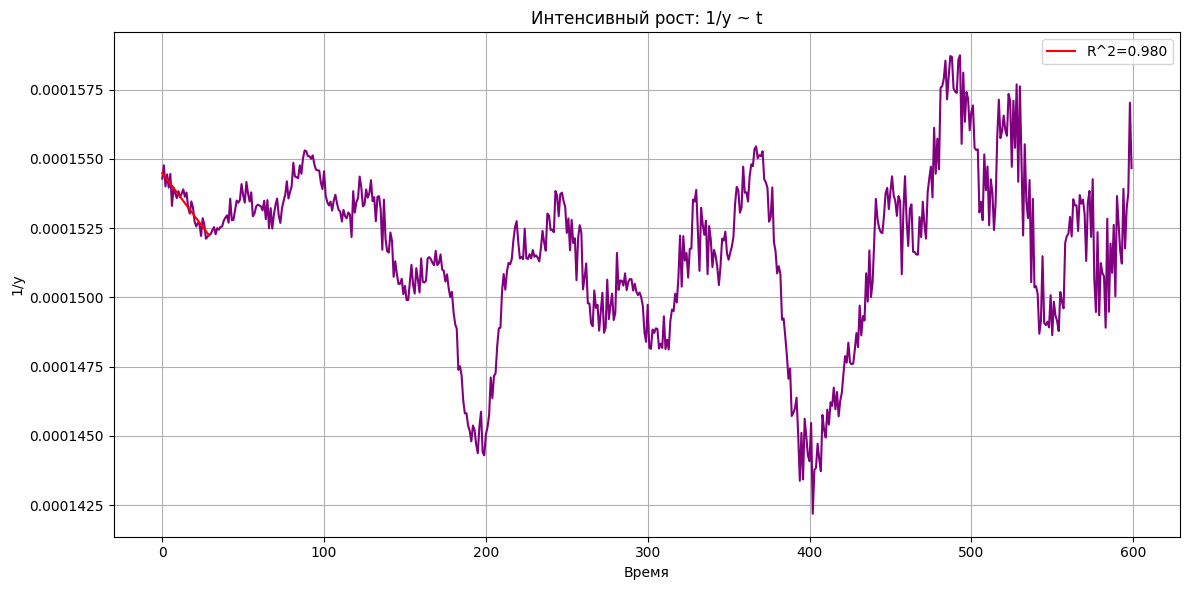

In [270]:
# Интенсивный рост: 1/y ~ t
y_inv = 1 / (y.values + 1e-10)
t = np.arange(len(y))

plt.figure(figsize=(12, 6))
plt.plot(t, y_inv, 'purple')
plt.title('Интенсивный рост: 1/y ~ t')
plt.xlabel('Время')
plt.ylabel('1/y')
plt.grid(True)


for seg in intense_segments[:1]:
    x_seg = np.arange(seg['start'], seg['end'])
    y_pred = seg['slope'] * x_seg + seg['intercept']
    plt.plot(x_seg, y_pred, 'r-', label=f"R^2={seg['r2']:.3f}")

plt.legend()
plt.tight_layout()
plt.show()

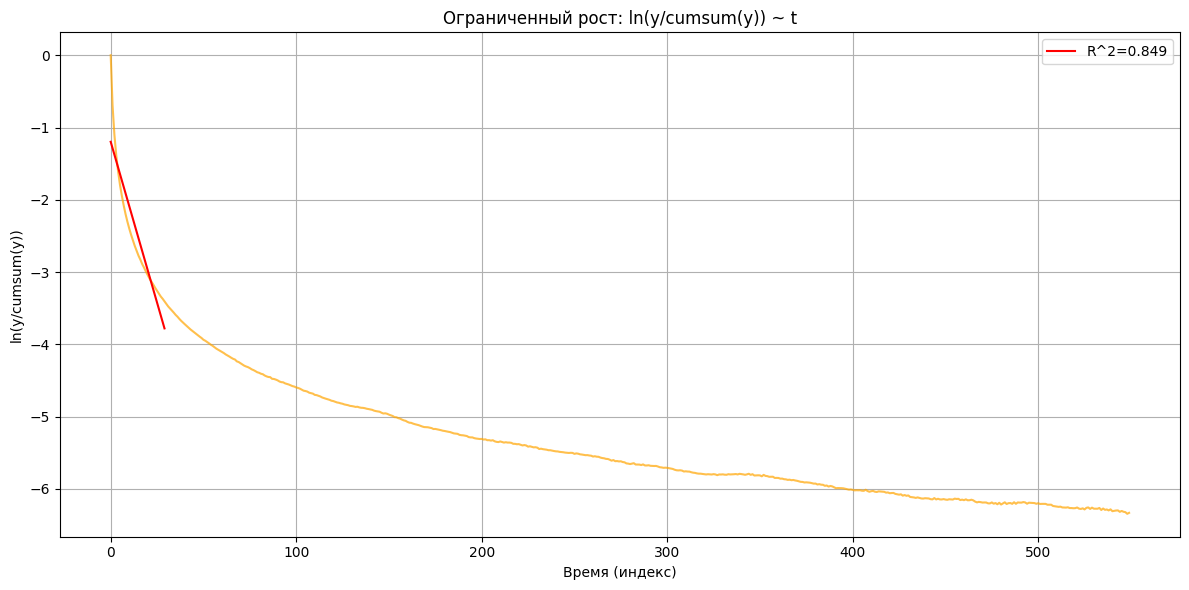

In [271]:
# Ограниченный рост: ln(y/cumsum(y)) ~ t
y_ratio = np.log(y.values[start_idx:] / (np.cumsum(y.values[start_idx:]) + 1e-10))
t_ratio = np.arange(len(y_ratio))

plt.figure(figsize=(12, 6))
plt.plot(t_ratio, y_ratio, 'orange', alpha=0.7)
plt.title('Ограниченный рост: ln(y/cumsum(y)) ~ t')
plt.xlabel('Время (индекс)')
plt.ylabel('ln(y/cumsum(y))')
plt.grid(True)

for seg in limited_segments[:1]:
    x_seg = np.arange(seg['start'], seg['end'])
    y_pred = seg['slope'] * x_seg + seg['intercept']
    plt.plot(x_seg, y_pred, 'r-', label=f"R^2={seg['r2']:.3f}")

plt.legend()
plt.tight_layout()
plt.show()

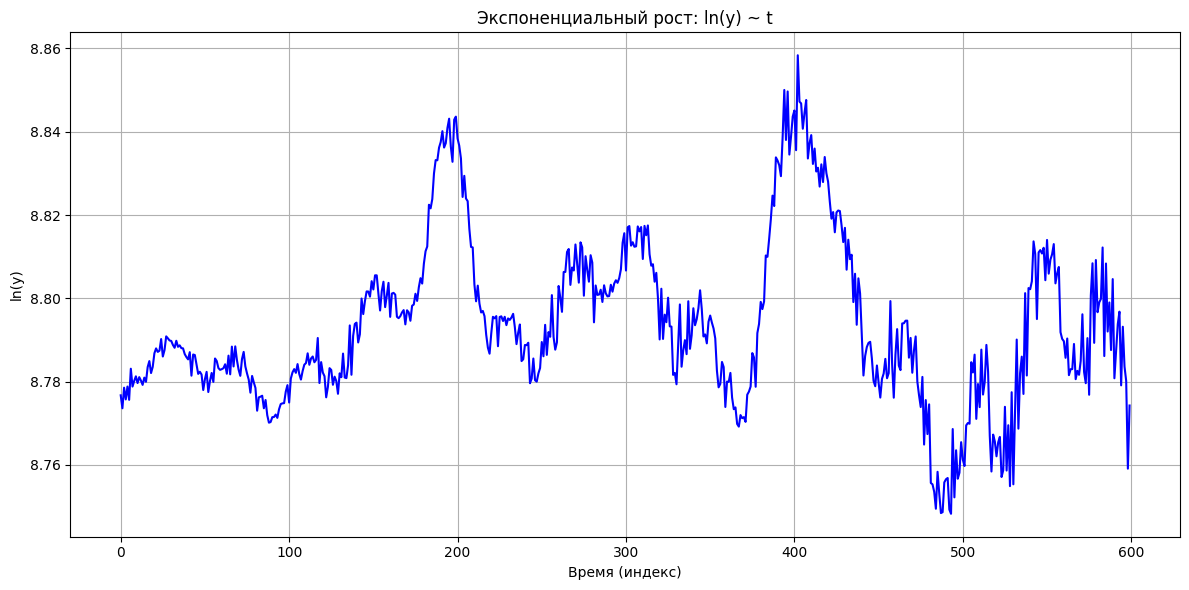

In [272]:
# Экспоненциальный рост: ln(y) ~ t
y_log = np.log(y.values + 1e-10)
t = np.arange(len(y))

plt.figure(figsize=(12, 6))
plt.plot(t, y_log, 'b-')
plt.title('Экспоненциальный рост: ln(y) ~ t')
plt.xlabel('Время (индекс)')
plt.ylabel('ln(y)')
plt.grid(True)
plt.tight_layout()
plt.show()

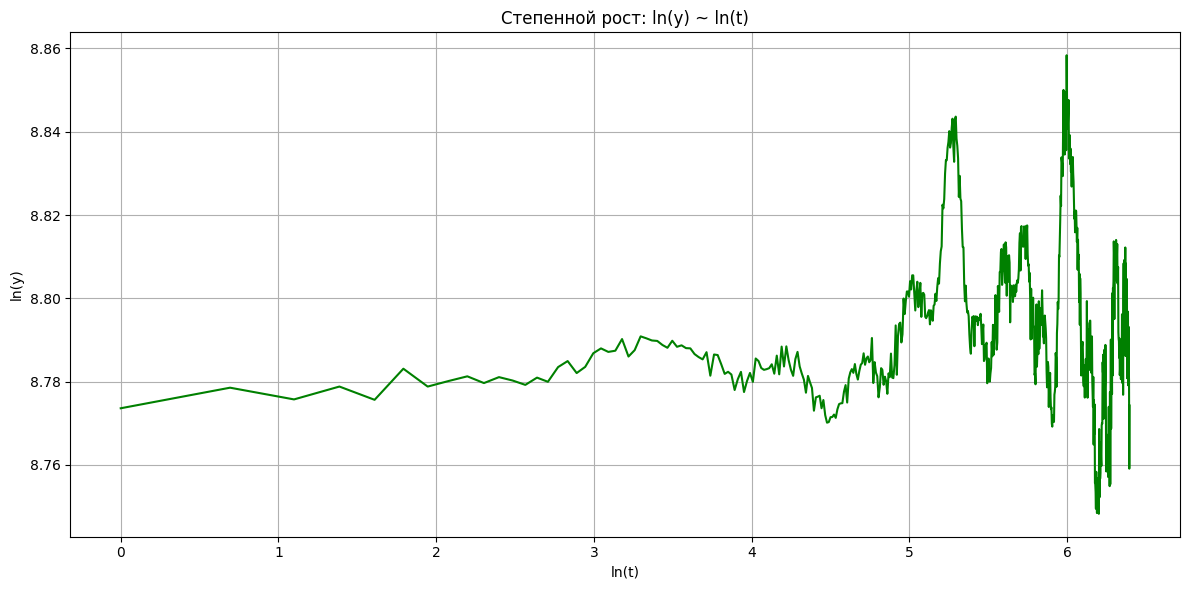

In [273]:
# Степенной рост: ln(y) ~ ln(t)
y_log = np.log(y.values[1:] + 1e-10)
t_log = np.log(np.arange(1, len(y)) + 1e-10)

plt.figure(figsize=(12, 6))
plt.plot(t_log, y_log, 'g-')
plt.title('Степенной рост: ln(y) ~ ln(t)')
plt.xlabel('ln(t)')
plt.ylabel('ln(y)')
plt.grid(True)
plt.tight_layout()
plt.show()

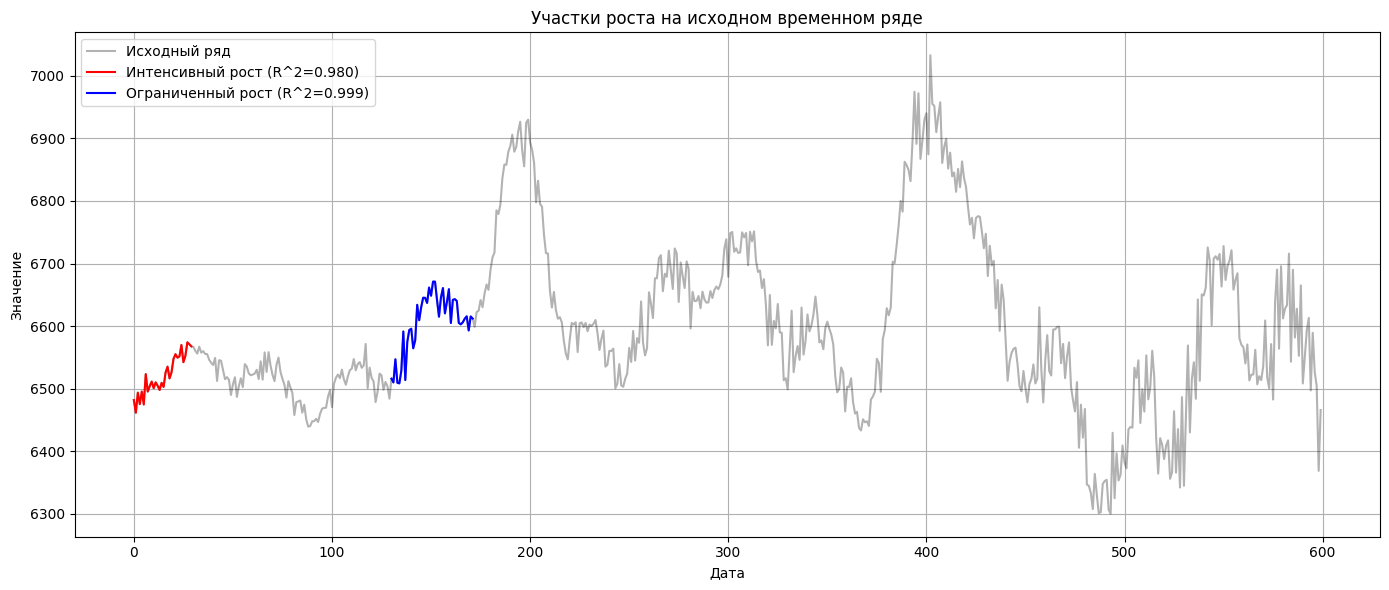

In [274]:
plt.figure(figsize=(14, 6))

plt.plot(y.index, y.values, 'k-', alpha=0.3, label='Исходный ряд')

best_intense = max(intense_segments, key=lambda x: x['r2'])
start = best_intense['start']
end = best_intense['end']

plt.plot(y.index[start:end], y.values[start:end],
         'r-', label=f'Интенсивный рост (R^2={best_intense["r2"]:.3f})')


best_limited = max(limited_segments, key=lambda x: x['r2'])
start = best_limited['start'] + start_idx
end = best_limited['end'] + start_idx

plt.plot(y.index[start:end], y.values[start:end],
         'b-', label=f'Ограниченный рост (R^2={best_limited["r2"]:.3f})')

plt.title('Участки роста на исходном временном ряде')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()